# Class 12: The Linear Probability Model and Logistic Regression

In [1]:
# Load the libraries.  
# Anaconda automatically installs sklearn.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

## Classification

* Very frequently, we have **categorical labels** in our data, together with features.  
* We will build up the concept of a two-class categorical label based on material we have already discussed.  
    * We will motivate the idea through the use of a **latent** label (or variable).
    * Like time series, we do not observe the underlying DGP.
    * Rather we observe whether or not something **occurred** based on the **realization of a latent index**.  
    * The observation iss $\{0, 1\}$ or $\{$not observed, observed$\}$.
* This area of statistical learning is called **classification**.
    * We seek to train a predictor function, $pred$, for a label using $K$ features, $x$.
    * $y_i = pred(x_{i1}, ..., x_{iK})$.
* The **realization** of this predictor, given a feature set, is sometimes called **"yhat"** or $\hat{y}$.
* It is easy to visualize conceptually the nature of this class of questions with scatterplots. 

In [2]:
# Generate some data for scatterplots.

random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)

Text(0.5,1,'A Scatterplot')

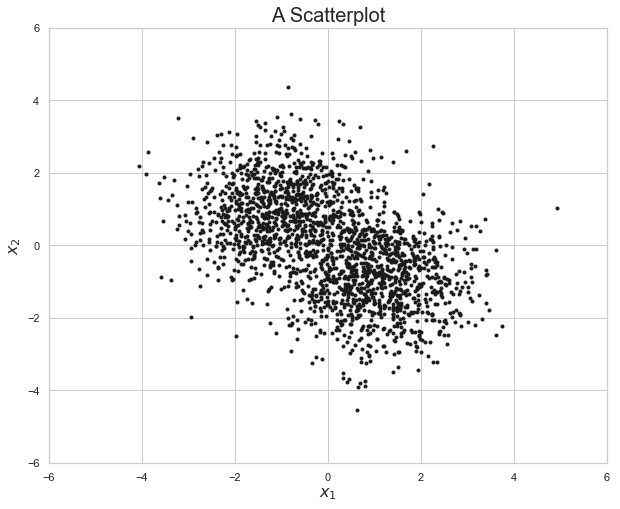

In [3]:
plt.figure(figsize=(10,8))
plt.plot(red, blue, 'k.')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

#### Notes
1. This scatterplot should be quite familiar by now.  
2. We have two features, $(x_1, x_2)$, and some label, which could be **anything**.
    * A row in our dataframe (or Excel spreadsheet) could be [house price, age, size].
3. Now imagine that the dots are **two flavors**, {red, blue}.
    * That is, a row in the dataframe contains three columns, a label and two features.
    * [flavor, $x_1$, $x_2$].  
    * For example, [red, -2, 2].

Text(0.5,1,'A Scatterplot with Red-Blue Labels')

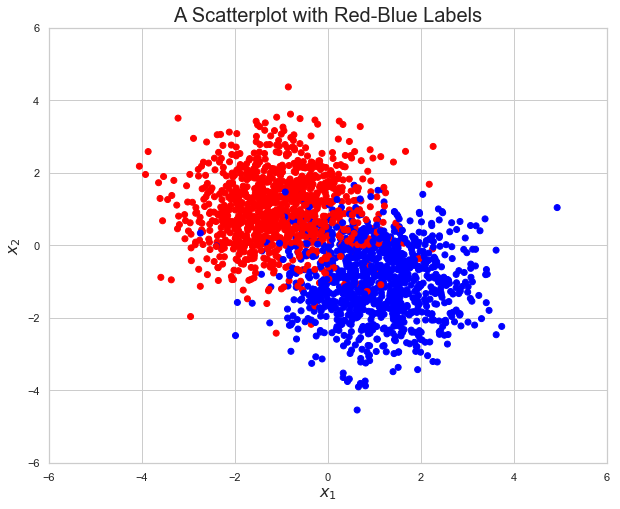

In [4]:
plt.figure(figsize=(10,8))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

#### How We Will Proceed
1. Start with an algorithm we have been using for the entire semester.
2. Turn to a very popular algorithm used for classification of labels with two classes.
    * 1 and 2 combined constitute a very large share of the algorithms used in applied data science.
3. Examine algorithms to predict multi-class labels. 

## Classification: The Linear Probability Model and The Logistic Classifier (or "Logit")

* The use case in multiple regression was to examine how house prices in Staten Island varied with characteristics (or features) of the houses themselves.  
    * This use case involved a continuous label, house prices.  
    * That is, $y$ was quantitative: the sales prices of single-family houses in Staten Island.  
    * Frequently, in data science, we face categorical labels, as above.  
* In economics, we call this the analysis of "limited dependent variables." 
* In computer science, it is classification.  
    * This different terminology refers to the **same thing**.  
* Because this classifier is the ground upon which data scientists of all stripes converge, it is an important methodological technique that I want you to understand **thoroughly**.

### Latent Labels (or Variables)

* One can think of categorical variable as being driven by an underlying DGP.
    * As with time series, we do not observe the continuous process.
    * We observe realizations.
* Consider the now familiar DGP: $y_i^*=x_i^\prime\beta+\epsilon_i$
* $y_i^*$ is a latent value for person *i* that is **unobserved by us**.  
    * For example, you do not observe the value I place on this canister of water.  
    * You simply observe me drinking it.  
    * In other words, you observe the outcome my choice set $\{$drink, not drink$\}$.  
    * Another example would be observing someone taking a taxi.  
    * You do not observe the value that someone places on the taxi ride.  You know that she has many alternative methods of transportation, all with varying values to her, but you observe the outcome of her choice.
* $x_i$ are a vector of features (or attributes or predictors or independent variables).  We observe these.
* $\beta$ is a vector that measures how features affect the latent index, which we will estimate statistically. 
* $\epsilon_i$ retains its status as our ignorance.  

**What do we observe?**

${\displaystyle d_i = }$
$\left\{ \begin{array}{l l} 
{1} & \quad \text{if person i takes a cab, which happens when } y_i^*\ge0\\ 
{0} & \quad \text{if person i does not take a cab, which happens when } y_i^*\lt0 \\
\end{array} \right.$  

## The Logistic Classifier

Again, we start with a sample of size, $N$.  We are going to change the linear model to the following:

$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$

We will then impose a distributional assumption on $\epsilon_i$, namely that it is logistically distributed.

${\displaystyle Pr(d_i=1) = \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}}$ 

We see immediately that this is NOT **a linear model** (that is, a model that is linear in $\beta$).

${\displaystyle Pr(d_i=0) = 1 - Pr(d_i=1) = 1 - \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)} = \frac{1}{1+\exp(x_i^\prime\beta)}}$

An "odds ratio":

${\displaystyle \frac{Pr(d_i=1)}{Pr(d_i=0)} = \frac{Pr(d_i=1)}{1 - Pr(d_i=1)} = \exp(x_i^\prime\beta)}$

This implies that the log-odds ratio (or "logit") is:

${\displaystyle \log\big(\frac{Pr(d_i=1)}{1 - Pr(d_i=1)}\big) = x_i^\prime\beta}$, which is linear in $\beta$.

To address the estimation of the parameters of interest, we need to construct a likelihood function that we will tell the computer to optimize.  Start by constructing the likelihood for observation $i$:

${\displaystyle l_i = Pr(d_i=1)^{d_i}\cdot Pr(d_i=0)^{(1-d_i)}=\frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

If we make some assumptions we can write:

${\displaystyle L = \prod_{i=1}^N l_i = \prod_{i=1}^N \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

Goal is to tell the machine to maximize $L$ with respect to $\beta$ given the data we have. 

Once we have done that, we can make probabilistic predictions (or classifications).

### The Confusion Matrix

* With a logit predictor, you can correctly predict a 1 or correctly predict 0.
* Obviously, you can incorrectly predict a 1 or incorrectly predict a 0.
* This is the basis of the confusion matrix, together with other measures of accuracy.

In [5]:
print("What is a confusion matrix, and what might we do with its elements?")
print("")
print()
table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

print("Zeros are negatives, and ones are positives")
print("Correctly predicting a 0 is a True Negative")
print("Correctly predicting a 1 is a True Positive")
print("Incorrectly predicting a 0 is a False Negative")
print("Incorrectly predicting a 1 is a Fale Positive")
print("")
print("The True Positive Rate is TP / (TP + FN)") 
print("The False Positive Rate is FP / (TN + FP)")
print("The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)")
print("The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction")

What is a confusion matrix, and what might we do with its elements?


╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛

Zeros are negatives, and ones are positives
Correctly predicting a 0 is a True Negative
Correctly predicting a 1 is a True Positive
Incorrectly predicting a 0 is a False Negative
Incorrectly predicting a 1 is a Fale Positive

The True Positive Rate is TP / (TP + FN)
The False Positive Rate is FP / (TN + FP)
The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)
The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction


### The Mean Squared Error and Bias/Variance Decomposition

For any predictor, $\hat{y}$, of label, $y$, with a dataframe of size $N$, the MSE ${\displaystyle =\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})^2}$.

In words, the MSE is the average of the **squared deviations** between our prediction and the truth.  We have already seen this measure.  Without the $\frac{1}{N}$, it is the Sum of Squared Residuals function, $SSR(\beta)$, that we minimized with the linear regression model.  We simply normalize it by the dataframe size (which does not alter the optimal values of $\beta$).  

In practice, we do not much care about the overall MSE, but the MSE associated with the test set, in which case we simply limit the calculation to the test set.  

It can be shown with some basic algebra that the MSE can be **decomposed**.  Namely,

$MSE \propto Var(\hat y) + Bias(\hat y)$

What do the **variance** and **bias** of a learning algorithm measure? 

**Variance** refers to the amount by which $\hat y$ would change if we train the algorithm using a different training set.  Since the training data are used to train the algorithm, a different training set would result in a different $\hat y$.  Ideally $\hat y$ should not considerably vary between training sets because an algorithm that has high variance implies that small changes in training sets can result in large changes in $\hat{y}$.  

**Generally, more flexible statistical methods have higher variance.**  That is, they are sensitive to their training sets.

**Bias** refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a simple representation.  For example, linear regression assumes that there is a linear relationship between between the label and the features, $\hat y = x'\hat \beta$.  It is unlikely that any real-life use case truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate of $\hat{y}$.  

**In general, more flexible statistical methods result in less bias.**  That is, including higher order terms (squares, cubics, or interactions) increases the predictive power (lower bias), but decreases our ability easily to interpret the results.

This is called the **bias-variance tradeoff**.

**It is inherent in any machine learning algorithm**.  